In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Notebook of the FloydHub blog post on "Introduction to Anomaly Detection in Python"

This notebook contains the thorough experiments as shown in the above-mentioned blog post. If you notice any flaws here, feel free let me know by opening an issue.

We will start off just by looking at the dataset from a _visual_ perspective and see if we can find the anomalies.

## Detecting anomalies just by seeing

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Shpw the plots in your Jupyter Notebook
%matplotlib inline
# Use a predefined style set
plt.style.use('ggplot')

In [24]:
from faker import Faker
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq
from pyod.models.knn import KNN
from pyod.utils import evaluate_print

Let's first create a dummy dataset for ourselves. The dataset will contain just two columns - 
- Name of the employees of an organization
- Salaries of those employees (in USD) within a range of 1000 to 2500 (Monthly)

For generating the names (and make them look like the real ones) we will use a Python library called `Faker` (read the documentation [here](https://faker.readthedocs.io/en/latest/index.html)). For generating salaries, we will use the good old `numpy`. After generating these, we will merge them in a `pandas` DataFrame. We are going to generate records for 100 employees. Let's begin. 

**Note**: Synthesizing dummy datasets for experimental purposes is indeed an essential skill.

In [5]:
#from faker import Faker
Faker.seed(4321)
fake = Faker()

# To ensure the results are reproducible
#fake.seed(4321)

names_list = []

fake = Faker()
for _ in range(100):
    names_list.append(fake.name())

# Verify if 100 names were generated
len(names_list)

100

In [6]:
# To ensure the results are reproducible
np.random.seed(7)

salaries = []
for _ in range(100):
    salary = np.random.randint(1000,2500)
    salaries.append(salary)

# Verify if 100 salariy values were generated
len(salaries)

100

In [14]:
# Create pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
     'Salary (in USD)': salaries
    })

# Print a subsection of the DataFrame
salary_df.shape
salary_df.info()
salary_df.head()

(100, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Person           100 non-null    object
 1   Salary (in USD)  100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


,Person,Salary (in USD)
0,Jason Brown,1175
1,Jacob Stein,2220
2,Cody Brown,1537
3,Larry Morales,1502
4,Jessica Hendricks,1211


Let's now manually change the salary entries of two individuals. In reality, this can actually happen for a number of reasons such as the data recording software may have got corrupted at the time of recording the respective data.

In [30]:
salary_df.at[16, 'Salary (in USD)'] = 23
salary_df.at[65, 'Salary (in USD)'] = 17

In [31]:
# Verify if the salaries were changed
print(salary_df.loc[16])
print(salary_df.loc[65])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
Name: 16, dtype: object
Person             Joyce Bishop
Salary (in USD)              17
Name: 65, dtype: object


### Boxplots are great! 

As mentioned in the earlier sections, the generation of anomalies within data directly depends on the generation of the data points itself. To simulate this, our approach is good enough to proceed. Let's now some basic statistics (like minimum value, maximum value, 1st quartile values etc.) in the form of a boxplot. 

Boxplot, because we get the following information all in just one place that too visually - 


![](https://pro.arcgis.com/en/pro-app/help/analysis/geoprocessing/charts/GUID-0E2C3730-C535-40CD-8152-80D794A996A7-web.png)

Courtesy: [This blog](https://pro.arcgis.com/en/pro-app/help/analysis/geoprocessing/charts/box-plot.htm)

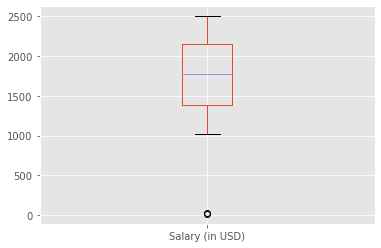

In [10]:
salary_df['Salary (in USD)'].plot(kind='box')
plt.show()

Notice the tiny circle point in the bottom. You instantly get a feeling of something wrong in there as _it deviates hugely from the rest of the data_. Now, you decide to look at the data from another visual perspective i.e. in terms of _histograms_. 

### How about histograms? 

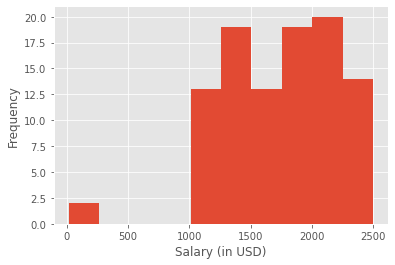

In [11]:
ax = salary_df['Salary (in USD)'].plot(kind='hist')
ax.set_xlabel('Salary (in USD)')
plt.show()

In the above histogram plot also, we can see there's one particular bin that is just not right _as it deviates hugely from the rest of the data_ (phrase repeated intentionally to put emphasis on the deviation part). We can also infer that there are only two employees for which the salaries seem to be distorted (look at the y-axis). 

So what might be an immediate way to confirm that the dataset contains anomalies? Let's take a look at the minimum and maximum values of the column `Salary (in USD)`.  

In [12]:
print('Minimum salary ' + str(salary_df['Salary (in USD)'].min()))
print('Maximum salary ' + str(salary_df['Salary (in USD)'].max()))

Minimum salary 17
Maximum salary 2498


Look at the **minimum value**. From the accounts department of this hypothetical organization, you got to know that the minimum salary of an employee there is $1000. But you found out something different. Hence, its worth enough to conclude that this is indeed an anomaly. Let's now try to look at the data from a different perspective other than just simply plotting it. 

**Note**: Although our dataset contains only one feature (i.e. `Salary (in USD)`) that contains anomalies but in reality, there can be a lot features which will have anomalies in them. Even there also, these little visualizations will help you a lot. 

## Clustering based approach for anomaly detection

We have seen how clustering and anomaly detection are closely related but they serve different purposes. But clustering can be used for anomaly detection. In this approach, we start by grouping the similar kind of objects. Mathematically, this similarity is measured by distance measurement functions like Euclidean distance, Manhattan distance and so on. Euclidean distance is a very popular choice when choosing in between several distance measurement functions. Let's take a look at what Euclidean distance is all about. 

### An extremely short note on Euclidean distance

If there are n points on a two-dimensional space(refer the following figure) and their coordinates are denoted by(x_i, y_i), then the Euclidean distance between any two points((x1, y1) and(x2, y2)) on this space is given by:

$$
\sqrt{\left(x_{1}-x_{2}\right)^{2}+\left(y_{1}-y_{2}\right)^{2}}
$$

We are going to use [K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering) which will help us cluster the data points (salary values in our case). The implementation that we are going to be using for `KMeans` uses Euclidean distance internally. Let's get started. 

In [32]:
# Convert the salary values to a numpy array
salary_raw = salary_df['Salary (in USD)'].values
salary_raw[16]
salary_raw[65]

23

17

In [33]:
# For compatibility with the SciPy implementation
#salary_raw = pok.reshape(-1, 1)
salary_raw = salary_raw.reshape(-1,1)
salary_raw = salary_raw.astype('float64')

We will now import the `kmeans` module from `scipy.cluster.vq`. SciPy stands for Scientific Python and provides a variety of convenient utilities for performing scientific experiments. Follow its documentation [here](https://docs.scipy.org/doc/). We will then apply `KMeans` to `salary_raw`. 

In [34]:
#from scipy.cluster.vq import kmeans

# Supply the data and the number of clusters to kmeans()
codebook, distortion = kmeans(salary_raw, 4)

In [35]:
codebook

array([[1776.84375   ],
       [  20.        ],
       [1287.3030303 ],
       [2264.54545455]])

In [36]:
distortion

119.12457386363636

In the above chunk of code, we fed the salary data points the `kmeans()`. We also specified the number of clusters to which we want to group the data points. `cookbook` is the centroids generated by `kmeans()` and `distortion` is the averagedEuclidean distance between the data points fed and the centroids generated by `kmeans()`. 

Let's assign the groups of the data points by calling th `vq()` method. It takes - 
- The data points
- The centroid as generated by the clustering algorithm (`kmeans()` in our case)

It then returns the groups of the data points and the distance between the observation and its nearest group.

In [37]:
#groups, cdist = cluster.vq.vq(salary_raw, codebook)
groups, cdist = vq(salary_raw, codebook)

In [38]:
print(list(zip(groups, cdist)))

[(2, 112.30303030303025), (3, 44.545454545454504), (0, 239.84375), (2, 214.69696969696975), (2, 76.30303030303025), (0, 142.15625), (3, 107.4545454545455), (3, 55.545454545454504), (3, 157.4545454545455), (0, 241.84375), (2, 57.696969696969745), (2, 78.69696969696975), (0, 222.84375), (0, 46.84375), (0, 127.15625), (3, 73.5454545454545), (1, 3.0), (3, 191.4545454545455), (2, 103.69696969696975), (0, 163.15625), (3, 165.5454545454545), (0, 46.15625), (2, 37.303030303030255), (3, 234.5454545454545), (3, 203.4545454545455), (3, 196.5454545454545), (3, 84.4545454545455), (3, 88.5454545454545), (2, 104.30303030303025), (0, 172.15625), (3, 128.5454545454545), (0, 13.84375), (3, 51.545454545454504), (2, 2.696969696969745), (2, 24.696969696969745), (2, 86.30303030303025), (3, 221.4545454545455), (0, 226.84375), (0, 4.84375), (2, 206.69696969696975), (3, 103.5454545454545), (3, 45.545454545454504), (3, 168.5454545454545), (0, 167.15625), (2, 30.303030303030255), (2, 112.69696969696975), (3, 133

Let's now plot the groups we have got. 

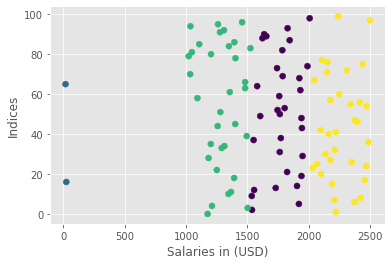

In [39]:
plt.scatter(salary_raw, np.arange(0,100), c=groups);
plt.xlabel('Salaries in (USD)');
plt.ylabel('Indices');
plt.show();

Can you point to the anomalies? I bet you can! 

The above method for anomaly detection is purely [unsupervised](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/) in nature. If we had the class-labels of the data points, we could have easily converted this to a [supervised learning](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/) problem, specifically a _classification_ problem. 

Shall we extend this? Well, why not? 

## Anomaly detection as a classification problem

To be able to treat the task of anomaly detection as classification task, we need a labeled dataset. Let's give our existing dataset some labels. 

We will first assign all the entries to the class of 0 and then we will manually edit the labels for those two anomalies. We will keep these class labels in a column named `class`. The label for the anomalies will be 1 (and for the normal entries the labels will be 0). 

In [40]:
# First assign all the instances to 
salary_df['class'] = 0

# Manually edit the labels for the anomalies
salary_df.at[16, 'class'] = 1
salary_df.at[65, 'class'] = 1

# Veirfy 
salary_df.loc[16]
salary_df.loc[65]

Person             Miss Amanda Harris MD
Salary (in USD)                       23
class                                  1
Name: 16, dtype: object

Person             Joyce Bishop
Salary (in USD)              17
class                         1
Name: 65, dtype: object

Let's take a look at the dataset again! 

In [41]:
salary_df.head()

,Person,Salary (in USD),class
0,Jason Brown,1175,0
1,Jacob Stein,2220,0
2,Cody Brown,1537,0
3,Larry Morales,1502,0
4,Jessica Hendricks,1211,0


We now have a binary classification task. We are going to use **proximity-based anomaly detection** for solving this task. The basic idea here is that the proximity of an anomaly data point to its nearest neighboring data points largely _deviates_ from the proximity of the data point to most of the other data points in the data set. Don't worry if this does not ring a bell now. Once, we visualize this, it will be clear. 

We are going to use the [k-NN classification method](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn) for this. Also, we are going to use a Python library called `PyOD` which is specifically developed for anomaly detection purposes. 

I really encourage you take a look at the official documentation of PyOD [here](https://pyod.readthedocs.io/). 

In [ ]:
# Importing KNN module from PyOD
#from pyod.models.knn import KNN

The column `Person` is not at all useful for the model as it is nothing but a kind of identifier. Let's prepare the training data accordingly.  

In [42]:
# Segregate the salary values and the class labels 
X = salary_df['Salary (in USD)'].values.reshape(-1,1)
y = salary_df['class'].values

In [43]:
# Train kNN detector
clf = KNN(contamination=0.02, n_neighbors=5)
clf.fit(X)

KNN(algorithm='auto', contamination=0.02, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

Let's discuss the two parameters we passed in to `KNN()` - 

- contamination - the amount of anomalies in the data (in percentage) which for our case is 2/100 = 0.02
- n_neighbors - number of neighbors to consider for measuring the proximity

Let's now get the prediction labels on the training data and then get the outlier scores of the training data. The outlier scores of the training data. The higher the scores are, the more abnormal. This indicates the overall abnormality in the data. These handy features makes `PyOD` a great utility for anomaly detection related tasks. 

In [44]:
# Get the prediction labels of the training data
y_train_pred = clf.labels_ 

# Outlier scores
y_train_scores = clf.decision_scores_  

Let's now try to evaluate `KNN()` with respect to the training data. 

In [45]:
#from pyod.utils import evaluate_print

# Evaluate on the training data
evaluate_print('KNN', y, y_train_scores)

KNN ROC:1.0, precision @ rank n:1.0


We see that the `KNN()` model was able perform exceptionally good on the training data. It provides three metrics and their scores - 
- [ROC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
- [Precision](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
- A confidence rank with which it gives the outlier scores. 

**Note**: While detecting anomalies, we almost always consider `ROC` and `Precision` as it gives a much better idea about the model's performance. We have also seen its significance in the earlier sections. 

We don't have any test data. But we can generate a sample salary value right? 

In [46]:
# A salary of $37 (an anomaly right?)
X_test = np.array([[37.]])

Let's now test how if the model could detect this salary value as an anomaly or not.

In [47]:
# Check what the model predicts on the given test data point
clf.predict(X_test)

array([1])

We can see the model predicts just right. Let's also see how the model does on a normal data point. 

In [48]:
# A salary of $1256
X_test_abnormal = np.array([[1256.]])

# Predict
clf.predict(X_test_abnormal)

array([0])

The model predicted this one as the normal data point which is correct. 